Scientific programming in Python (Winter 2025/26)

# Sheet 04: Python constructs

## Introduction

Solve this sheet in your group. Once done, upload your solution to your group's folder (under [`Groups`](https://studip.uni-osnabrueck.de/dispatch.php/course/files/index/6e9e531b6e84cadd07ac27fd03fb8493?cid=64105ba596df4fcc36ec266431aac621)).  Please do so before **November 25th, 2025**.  You should be able to explain your solution to your tutor in the feedback meeting.  You should solve at least 50% of the exercises on (N-1) of the  sheets, to participate in the project work of this course, which will start after the new year break.

**Note:** Due to high attendance, we are splitting the tutor sessions. Each exercise group (currently 6 participants) must divide into two subgroups of 3. Subgroup A attends Week 1, Subgroup B attends Week 2, then A attends Week 3, B attends Week 4, and so on. Please coordinate within your group to decide who attends each week and ensure that no more than three participants attend any session.
Exercise sheets will be handed out every second week.

Maik and Lay worked on this sheet.

## Goal of this Sheet

This sheet practices the use some Python constructs, like some aspects of Python functions as well as Iterable and Generators. It will also make use of numpy and matplotlib.

Setup: you need to have `numpy` and `matplotlib` installed for this sheet. Run the following cell to check:

In [2]:
import numpy as np
import matplotlib as mpl

print("numpy:", np.__version__)
print("matplotlib:", mpl.__version__)

numpy: 2.3.3
matplotlib: 3.10.6


## Exercise 1: Functions basics and higher-order functions (Stroop RT cleanup)

Motivation: Define functions, use keyword-only arguments, pass functions to other functions (higher-order programming), and use anonymous functions (lambda) to customize behavior. We use a Stroop-like reaction time (RT) dataset.

Useful docs:
- sorted: https://docs.python.org/3/library/functions.html#sorted
- map/filter: https://docs.python.org/3/library/functions.html#map and https://docs.python.org/3/library/functions.html#filter
- functools.partial: https://docs.python.org/3/library/functools.html#functools.partial

In [3]:
from typing import Callable, Iterable, Iterator, Any, Optional
import numpy as np

rng = np.random.default_rng(42)

# Simulate trial-level data
n_subj = 12
trials_per_cond = 80
conds = ["congruent", "incongruent"]

rows = []
for s in range(1, n_subj + 1):
    for cond in conds:
        mu = 520 if cond == "congruent" else 600
        sd = 80 if cond == "congruent" else 90
        rts = np.clip(rng.normal(mu, sd, size=trials_per_cond), 150, 1400)  # creating a clipped normal distr
        p_correct = 0.95 if cond == "congruent" else 0.85
        correct = rng.random(trials_per_cond) < p_correct  
        for i in range(trials_per_cond):
            rows.append((s, cond, float(rts[i]), bool(correct[i])))

dtype = np.dtype([("subject", int), ("condition", "U12"), ("rt_ms", float), ("correct", bool)])
data = np.array(rows, dtype=dtype)
len(data), data[:3]

(1920,
 array([(1, 'congruent', 544.37736638,  True),
        (1, 'congruent', 436.8012715 ,  True),
        (1, 'congruent', 580.03609566,  True)],
       dtype=[('subject', '<i8'), ('condition', '<U12'), ('rt_ms', '<f8'), ('correct', '?')]))

**(a)** Implement `clean_rts`

In [4]:
def clean_rts(rts: np.ndarray, *, clip_min: float = 200.0, clip_max: float = 1200.0, mask: Optional[np.ndarray] = None) -> np.ndarray:
    """
    Clean a vector of reaction times by optional masking and clipping.

    Arguments
    ----------
    rts : np.ndarray
        One-dimensional array of reaction times in milliseconds.
    clip_min : float, keyword-only
        Minimum allowable RT (ms). Values below are clipped to this bound.
    clip_max : float, keyword-only
        Maximum allowable RT (ms). Values above are clipped to this bound.
    mask : Optional[np.ndarray], keyword-only
        Optional boolean mask of the same length as rts. If provided,
        only entries where mask is True are retained before clipping.

    Returns
    -------
    np.ndarray
        A 1D NumPy array of cleaned RTs after applying the optional mask
        and clipping to [clip_min, clip_max].

    Main idea
    ---------
    Data cleaning for RTs commonly removes incorrect trials and clips
    implausible fast/slow responses to a reasonable window so that
    downstream statistics are robust to outliers.
    """
    # YOUR CODE HERE
    clean_rts = np.clip(rts, clip_min, clip_max)
    if mask is not None:
        clean_rts[mask]
    return clean_rts
    # question: should we still leave asserts here?
    raise NotImplementedError("Implement clean_rts")

# Quick check
sub = 1
sel = (data["subject"] == sub) & (data["condition"] == "congruent")
rts = data["rt_ms"][sel]
out = clean_rts(rts)
assert out.ndim == 1 and (out >= 200).all() and (out <= 1200).all()

**(b)** Implement `subject_mean`

In [5]:
print(data)
np.shape(data)

[( 1, 'congruent', 544.37736638,  True)
 ( 1, 'congruent', 436.8012715 ,  True)
 ( 1, 'congruent', 580.03609566,  True) ...
 (12, 'incongruent', 574.95716084,  True)
 (12, 'incongruent', 642.340532  , False)
 (12, 'incongruent', 660.13780592,  True)]


(1920,)

In [6]:
def subject_mean(data: np.ndarray, subject: int, condition: str, agg: Callable[[np.ndarray], float] = np.mean, only_correct: bool = True) -> float:
    """
    Compute a per-subject mean (or other aggregate) RT for a given condition.

    Arguments
    ----------
    data : np.ndarray
        Structured array with fields ('subject', 'condition', 'rt_ms', 'correct').
    subject : int
        Subject identifier to select.
    condition : str
        Condition label to select (e.g., 'congruent' or 'incongruent').
    agg : Callable[[np.ndarray], float]
        Aggregation function mapping a 1D array of RTs to a scalar
        (e.g., numpy.mean, numpy.median).
    only_correct : bool
        If True, restrict the aggregate to trials where 'correct' is True.

    Returns
    -------
    float
        The aggregate RT for the given subject and condition.

    Main idea
    ---------
    Filter rows matching the subject and condition, optionally restrict
    to correct trials using a boolean mask, clean RTs via clipping, and
    then apply a user-supplied aggregation function to compute a summary.
    """

     #   if trial[0] == subject & trial[1] == condition:
    filtered = [entry[2] for entry in data if entry[0] == subject and entry[1] == condition]
    return agg(np.array(filtered))

    raise NotImplementedError("Implement subject_mean")

# Quick check
m = subject_mean(data, 1, "incongruent", agg=np.mean)
assert isinstance(m, float)

**(c)** Compute congruency effect per subject and sort by effect using a lambda key

In [36]:
def congruency_effect_for_subject(data, sub: int) -> float:
    """
    Compute a subject-specific congruency effect (incongruent - congruent).

    Arguments
    ----------
    sub : int
        Subject identifier.

    Returns
    -------
    float
        Difference between mean incongruent and mean congruent RTs
        for correct trials.

    Main idea
    ---------
    Use subject_mean to compute condition-specific means and then take
    the difference as a measure of interference in a Stroop-like task.
    """
    incongruent=  subject_mean(data, sub, "incongruent", agg=np.mean)
    congruent = subject_mean(data, sub, "congruent", agg=np.mean)
    return incongruent - congruent
    

effects = [congruency_effect_for_subject(data, s) for s in range(1, n_subj + 1)]
# Now obtain a sorted list of effects, ordered by descending effects size
effects.sort(reverse=True)

# Quick check
assert len(effects) == n_subj

# Output first three entries:
print(effects[:3])

[np.float64(104.88052860204027), np.float64(88.80510211252601), np.float64(86.73675194045194)]


In [37]:
np.std([1,2,])

np.float64(0.5)

**(d)** Plot per-condition mean RTs with ~95% CI across subjects

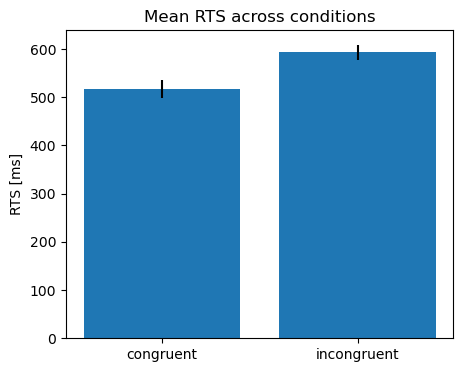

In [52]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 4))

incongruent =  [subject_mean(data, sub, "incongruent", agg=np.mean) for sub in range(1,n_subj+1)]
congruent    = [subject_mean(data, sub, "congruent", agg=np.mean) for sub in range(1,n_subj+1)]
mean_rts = [np.mean(congruent),np.mean(incongruent)]

# Take 2x standard deviation per condition to calculate size of the 95% CI
stds_rts = [np.std(congruent)*2, np.std(incongruent)*2]
labels = ["congruent", "incongruent"]

ax.bar(labels, height=mean_rts, yerr=stds_rts)
ax.set_ylabel('RTS [ms]')
ax.set_title('Mean RTS across conditions')


plt.show()

## Exercise 2: Using functions as arguments - Psychometric function fitting (grid/MC)

Motivation: Pass functions as arguments to build a flexible estimator for a psychometric curve (e.g., probability correct vs. stimulus contrast) using a binomial likelihood evaluated on a grid.

Useful docs:
- itertools.product: https://docs.python.org/3/library/itertools.html#itertools.product

In [1]:
import math
import time
from typing import Callable, Iterable, Iterator, Any, Optional
import numpy as np
from itertools import product

rng = np.random.default_rng(42)

# Simulate data
contrasts = np.array([0.02, 0.04, 0.08, 0.12, 0.16, 0.24, 0.32, 0.48])
true_alpha, true_beta = 0.12, 0.06
ntrials = 40
rows = []
for x in contrasts:
    p = 1.0 / (1.0 + np.exp(-(x - true_alpha) / true_beta))
    y = rng.random(ntrials) < p
    for yy in y:
        rows.append((x, int(yy)))
data = np.array(rows, dtype=[("x", float), ("y", int)])

# data is a "structured" numpy array, with 
# data["x"] containing the x-values (as float) and 
# data["y"] the corresponding responses (0 or 1 as int)
print(np.random.choice(data, 6))

[(0.32, 1) (0.48, 1) (0.16, 1) (0.48, 1) (0.48, 1) (0.24, 1)]


In [ ]:
def logistic(x: np.ndarray, alpha: float, beta: float) -> np.ndarray:
    """
    Logistic psychometric function mapping stimulus intensity to response probability.

    Arguments
    ----------
    x : np.ndarray
        Stimulus intensities (e.g., contrast), 1D array.
    alpha : float
        Threshold/offset parameter (location of 50% point).
    beta : float
        Slope/scale parameter controlling the steepness.

    Returns
    -------
    np.ndarray
        Probabilities in [0, 1] for each element of x.

    Main idea
    ---------
    Use the standard logistic transformation 1 / (1 + exp(-(x - alpha)/beta)).
    """
    # YOUR CODE HERE
    return 1.0 / (1.0 + np.exp(-(x - alpha) / beta))
    

In [8]:
def neg_log_likelihood(
    data: np.ndarray,
    model: Callable[[np.ndarray, tuple[float, float]], np.ndarray],
    theta: tuple[float, float]
) -> float:
    """
    Bernoulli negative log-likelihood for binary response data and a model function.

    Arguments
    ----------
    data : np.ndarray
        Structured array with fields 'x' (intensity) and 'y' (0/1 responses).
    model : Callable[[np.ndarray, tuple[float, float]], np.ndarray]
        Function f(x, theta) that returns probabilities for each x given parameters theta.
    theta : tuple[float, float]
        Model parameters (e.g., (alpha, beta) for the logistic).

    Returns
    -------
    float
        The negative log-likelihood summed over all trials.

    Main idea
    ---------
    Evaluate p = model(x, theta), clip to avoid log(0), and compute
    -(y log p + (1 - y) log(1 - p)) summed across observations.
    """
    # YOUR CODE HERE
    nll = .0
    for (x,y) in zip(data["x"], data["y"]):
        p = np.clip(model(x, *theta), a_min=0.00001, a_max=1)
        nll += -(y * np.log(p) + (1 - y) * np.log(1 - p))
    return nll

In [9]:
neg_log_likelihood(data, logistic, [0.12,0.06])

np.float64(135.06589255283924)

In [10]:
# Grid search for (alpha, beta)

alphas = np.linspace(0.02, 0.3, 60)
betas = np.linspace(0.02, 0.15, 60)
best = (None, np.inf)
for (a,b) in product(alphas, betas):
    # compute the negative log likelihood using `neg_log_likelihood` from above.
    # pass the `logistic` function as a model, with parameters a and b
    # Hint: use a pair (a, b) to pass theta an think how you have to pass
    # the `logistic` function to correctly process both parameters
    # YOUR CODE HERE
    nll = neg_log_likelihood(data, logistic, (a,b))
    if nll < best[1]:
        best = ((a, b), nll)

best

((np.float64(0.11966101694915254), np.float64(0.057457627118644064)),
 np.float64(134.99903166800414))

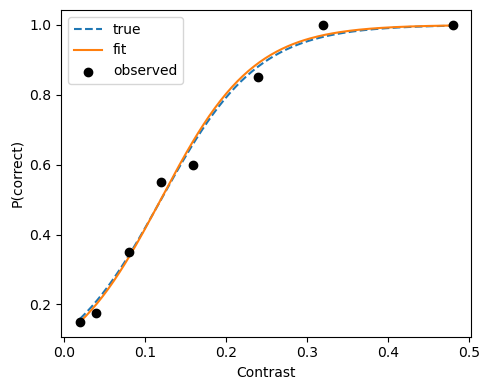

In [11]:
# Plot fit
import matplotlib.pyplot as plt

xs = np.linspace(contrasts.min(), contrasts.max(), 200)
a_hat, b_hat = best[0]
phat = logistic(xs, a_hat, b_hat)
ptrue = logistic(xs, true_alpha, true_beta)
pobs = [data["y"][data["x"] == x].mean() for x in contrasts]

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(xs, ptrue, "--", label="true")
ax.plot(xs, phat, "-", label="fit")
ax.scatter(contrasts, pobs, color="k", zorder=3, label="observed")
ax.set_xlabel("Contrast")
ax.set_ylabel("P(correct)")
ax.legend()
plt.tight_layout()
plt.show()

## Exercise 3: Iterables, iterators, and generators

**(a)** TrialBlock class

Motivation: Implement a custom iterable using dunder methods to represent a block of trials. Provide iteration, length, and optional shuffling.

Useful docs:
- Iterator protocol (iter, next): https://docs.python.org/3/glossary.html#term-iterator

In [ ]:
from typing import Callable, Iterable, Iterator, Any, Optional
import numpy as np
from dataclasses import dataclass

rng = np.random.default_rng(42)

# The "decorator" '@dataclass' turns the class into a "dataclass" allowing to pass properties 
# (stimuli, n_repeats, shuffle) as arguments to the constructor. Apart from that, the class can
# still be used like a normal python class.
@dataclass
class TrialBlock:
    """
    Iterable container for experimental trials composed of repeated stimuli.

    Attributes
    ----------
    stimuli : list[str]
        Base list of stimulus labels (e.g., colors, words).
    n_repeats : int
        How many times to repeat the base list in one block.
    shuffle : bool
        If True, shuffle the repeated list before iteration using a global RNG.

    Main idea
    ---------
    Encapsulate a trial schedule as an iterable object that yields
    (trial_index, stimulus) pairs. Implement __len__ for convenience.
    """
    stimuli: list[str]
    n_repeats: int = 1
    shuffle: bool = False

    def __iter__(self) -> Iterator[tuple[int, str]]:
        """
        Return an iterator over (trial_index, stimulus) pairs.

        Yields
        ------
        tuple[int, str]
            The sequential index (0-based within the block) and the stimulus label.

        Main idea
        ---------
        Build the repeated list of stimuli (optionally shuffled) and then
        yield index–stimulus pairs in order.
        """
        # YOUR CODE HERE
        raise NotImplementedError("__iter__ not implemented")

    def __len__(self) -> int:
        """
        Total number of trials in the block.

        Returns
        -------
        int
            len(stimuli) * n_repeats.

        Main idea
        ---------
        Report the size to support len(block) and pre-allocation patterns.
        """
        # YOUR CODE HERE
        raise NotImplementedError("__len__ not implemented")

# Demonstration
tb = TrialBlock(["RED", "BLUE", "GREEN"], n_repeats=2, shuffle=True)
print("len:", len(tb))
print("first 5:", list(tb)[:5])

**(b)** Exercise 6: Generators with state - Rapid Serial Visual Presentation (RSVP) stream

Motivation: Implement a generator that yields RSVP items (time, stimulus, is_target), then write a consumer that marks hits and false alarms given response times. Demonstrate generator composition and use of any/all.

Useful docs:
- enumerate: https://docs.python.org/3/library/functions.html#enumerate
- any/all: https://docs.python.org/3/library/functions.html#any

In [ ]:
def rsvp_stream(stimuli: list[str], isi_ms: int, target: str) -> Iterator[tuple[int, str, bool]]:
    """
    Generate an RSVP stream as time-stamped stimuli with target flags.

    Arguments
    ----------
    stimuli : list[str]
        Sequence of stimulus labels to present in order.
    isi_ms : int
        Inter-stimulus interval in milliseconds (each item shown at t, next at t+isi).
    target : str
        The label that should be considered a target.

    Yields
    ------
    tuple[int, str, bool]
        Triples of (time_ms, stimulus_label, is_target) for each item.

    Main idea
    ---------
    Increment a running time by the fixed ISI and yield one record per stimulus,
    marking whether each item equals the target label.
    """
    # YOUR CODE HERE
    raise NotImplementedError("Implement rsvp_stream")

# sanity check
assert tuple(rsvp_stream(["A","X","B"], 150, "X")) == ((0, 'A', False), (150, 'X', True), (300, 'B', False))

In [ ]:
def detect(stream: Iterable[tuple[int, str, bool]], response_times_ms: list[int], window_ms: int = 500) -> dict[str, int]:
    """
    Consume an RSVP stream and response times to count hits and false alarms.

    Arguments
    ----------
    stream : Iterable[tuple[int, str, bool]]
        RSVP sequence of (time_ms, stimulus_label, is_target) tuples.
    response_times_ms : list[int]
        List of keypress times (ms) relative to the start of the stream.
    window_ms : int
        Response window (ms) after a target within which a response counts as a hit.

    Returns
    -------
    dict[str, int]
        Dictionary with counts: {"hits": H, "fas": F}.

    Main idea
    ---------
    For each target in the stream, check if there exists an unused response
    within [t, t+window_ms]; count as a hit and mark the response used.
    For non-targets, count responses that occur before that time as false alarms
    (simplified rule for illustration).
    """
    # YOUR CODE HERE
    raise NotImplementedError("Implement detect")

res = detect(rsvp_stream(["A","X","B"], 150, "X"), (30, 210), window_ms=100)
res

In [3]:
# Simulate a stream and responses; compute rates and plot
import matplotlib.pyplot as plt

stimuli = ["A","B","C","X","D","E","X","F","G","H","X","I","J","K"]
isi_ms = 150  # interstimuli interval
target = "X"
stream = list(rsvp_stream(stimuli, isi_ms, target))
response_times = [160, 330, 910, 1670]  # ms

res = detect(iter(stream), response_times, window_ms=400)
print(res)

# Plot stream and responses
ts = [t for (t, s, it) in stream]
is_t = [it for (t, s, it) in stream]

fig, ax = plt.subplots(figsize=(8, 3))
ax.vlines(ts, 0, 1, color=np.where(is_t, "tab:red", "tab:gray"), lw=2)
ax.scatter(response_times, [1.05]*len(response_times), marker="v", color="tab:blue", label="responses")
ax.set_ylim(-0.1, 1.2)
ax.set_xlabel("Time (ms)")
ax.set_yticks([])
ax.set_title("RSVP stream (targets red) with responses")
ax.legend()
plt.tight_layout()
plt.show()

NameError: name 'rsvp_stream' is not defined